<a href="https://colab.research.google.com/github/yangchang-n/Src-sepd-Note-Generator/blob/main/ML/LSTM_attempt001.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
FIG_SIZE = (15, 10)
file = '' # Music file path
bpm = 200 # BPM of music
sample_rate = bpm * 100

In [ ]:
# Display Waveform
signal, sample_rate = librosa.load(file, sr = sample_rate)
print('signal shape : ', signal.shape)
print('length : ', signal.shape[0] / float(sample_rate), 'secs')

In [ ]:
plt.figure(figsize = FIG_SIZE)
librosa.display.waveshow(signal, sr = sample_rate, alpha = 0.4)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform')

In [ ]:
# FFT -> Power Spectrum
fft = np.fft.fft(signal)
spectrum = np.abs(fft)
f = np.linspace(0, sample_rate, len(spectrum))
left_spectrum = spectrum[ : int(len(spectrum) / 2)]
left_f = f[ : int(len(spectrum) / 2)]

print('fft shape : ', fft.shape)
print('spectrum shape : ', spectrum.shape)
print('f shape : ', f.shape)
print('left_spectrum shape : ', left_spectrum.shape)
print('left_f shape : ', left_f.shape)

In [ ]:
plt.figure(figsize = FIG_SIZE)
plt.plot(left_f, left_spectrum, alpha = 0.4)
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('Power spectrum')

In [ ]:
# STFT -> Spectrogram
n_fft = int(60 / bpm * sample_rate) # Window in num of samples
hop_length = int(n_fft / 4) # In num of samples

# Calculate duration hop length and window in seconds
hop_length_duration = float(hop_length) / sample_rate
n_fft_duration = float(n_fft) / sample_rate

print("STFT hop length duration is : {}s".format(hop_length_duration))
print("STFT window duration is : {}s".format(n_fft_duration))

STFT hop length duration is : 0.075s
STFT window duration is : 0.3s


In [ ]:
# Perform STFT
stft = librosa.stft(signal, n_fft = n_fft, hop_length = hop_length)

# Calculate abs values on complex numbers to get magnitude
spectrogram = np.abs(stft)

In [ ]:
# Display spectrogram
plt.figure(figsize = FIG_SIZE)
librosa.display.specshow(spectrogram, sr = sample_rate, hop_length = hop_length)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar()
plt.title('Spectrogram')

In [ ]:
# Cast amplitude to decibels
# Apply logarithm to cast amplitude to decibels
log_spectrogram = librosa.amplitude_to_db(spectrogram)

plt.figure(figsize = FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr = sample_rate, hop_length = hop_length)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.colorbar(format = '%+2.0f dB')
plt.title('Spectrogram (dB)')

In [ ]:
# MFCCs
# Extract 13 MFCCs
MFCCs = librosa.feature.mfcc(y = signal, sr = sample_rate, n_fft = n_fft, hop_length = hop_length, n_mfcc = 13)

# Display MFCCs
plt.figure(figsize = FIG_SIZE)
librosa.display.specshow(MFCCs, sr = sample_rate, hop_length = hop_length)
plt.xlabel('Time')
plt.ylabel('MFCC coefficients')
plt.colorbar()
plt.title('MFCCs')
plt.show()

In [ ]:
print(MFCCs.shape)
print(MFCCs[:4])

MFCCs_T = np.transpose(MFCCs)
print(MFCCs_T.shape)
print(MFCCs_T[:4])

In [ ]:
notefile = '' # Music's note-info file path
bpm = 200 # BPM of music
note_per_beat = 4
note_time_dist = 60 / (bpm * note_per_beat)
music_length_sec = 260 # sec(s)
button_count = 4 # Count of buttons in note-info file
noteinfo = [[0] * button_count for i in range(round(music_length_sec / note_time_dist) + 1)]

fileinfo = []

with open(notefile, 'r') as f :
  for line in f :
    lineinfo = line.split(',')
    fileinfo.append([int(lineinfo[0]), int(lineinfo[2])])

print(note_time_dist * 1000)

for i in range(len(fileinfo)) :
  noteinfo[round(fileinfo[i][1] / (note_time_dist * 1000))][int((fileinfo[i][0] - 64) / 128)] = 1

noteinfo_np = np.array(noteinfo)

In [ ]:
print(MFCCs_T.shape)
print(noteinfo_np.shape)

(3468, 13)
(3468, 4)


In [ ]:
std = StandardScaler()
std.fit(MFCCs_T)
MFCCs_T_scaled = std.transform(MFCCs_T)

In [ ]:
def transform_sequential_dataset(dataset, timestep) :
  sequential_dataset = []
  for i in range(len(dataset)) :
    if i < timestep :
      temp = [[0] * len(dataset[0])] * (timestep - i - 1)
      temp.extend(dataset[:i + 1])
      sequential_dataset.append(temp)
    else :
      sequential_dataset.append(dataset[i - timestep + 1 : i + 1])
  sequential_dataset = np.array(sequential_dataset)
  return sequential_dataset

In [ ]:
MFCCs_T_seq = transform_sequential_dataset(MFCCs_T, 32)
MFCCs_T_scaled_seq = transform_sequential_dataset(MFCCs_T_scaled, 32)

In [ ]:
print(MFCCs_T_seq.shape)
print(noteinfo_np.shape)

(3468, 32, 13)
(3468, 4)


In [ ]:
# x_train, x_test, y_train, y_test = train_test_split(MFCCs_T_seq, noteinfo_np, test_size = 0.2)
x_train, x_test, y_train, y_test = train_test_split(MFCCs_T_scaled_seq, noteinfo_np, test_size = 0.2)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(8, return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])),
    tf.keras.layers.Dropout(rate = 0.2),
    tf.keras.layers.Dense(8),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4, activation = 'sigmoid')
])
model.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_66 (LSTM)              (None, 32, 8)             704       
                                                                 
 dropout (Dropout)           (None, 32, 8)             0         
                                                                 
 dense_41 (Dense)            (None, 32, 8)             72        
                                                                 
 flatten_2 (Flatten)         (None, 256)               0         
                                                                 
 dense_42 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 1804 (7.05 KB)
Trainable params: 1804 (7.05 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
model.compile(optimizer = 'adam', loss = 'MSE', metrics = ['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, epochs = 200, validation_split = 0.2)

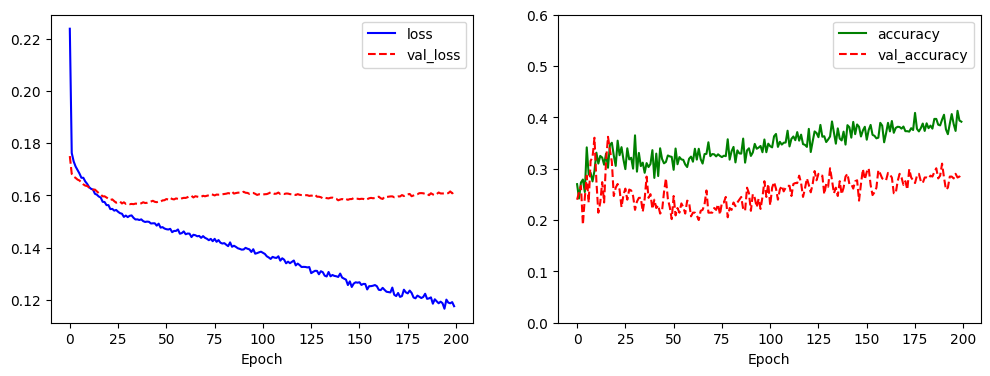

[0.16851627826690674, 0.24495677649974823]

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-', label = 'loss')
plt.plot(history.history['val_loss'], 'r--', label = 'val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], 'g-', label = 'accuracy')
plt.plot(history.history['val_accuracy'], 'r--', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylim(0, 0.6)
plt.legend()

plt.show()

model.evaluate(x_test, y_test, verbose = 0)

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
prediction = model.predict(transform_sequential_dataset(MFCCs_T, 32))
print(prediction)

In [ ]:
count = 0
for i in range(len(prediction)) :
  for j in range(len(prediction[0])) :
    if prediction[i][j] > 0.25 :
      count += 1
ratio = count / (len(prediction) * 4)

print(count, ratio)

3393 0.24459342560553632


In [ ]:
count = 0
for i in range(len(noteinfo_np)) :
  for j in range(len(noteinfo_np[0])) :
    if noteinfo_np[i][j] == 1 :
      count += 1
ratio = count / (len(noteinfo_np) * 4)

print(count, ratio)

3267 0.23551038062283736


In [ ]:
answer = [[0] * button_count for i in range(round(music_length_sec / note_time_dist) + 1)]
for i in range(len(prediction)) :
  for j in range(len(prediction[0])) :
    if prediction[i][j] > 0.25 :
      answer[i][j] = 1